In [1]:
import numpy as np
import pickle
from astropy.io import fits
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
%pylab inline
from galpy.orbit import Orbit
from scipy import ndimage, signal, interpolate
import gd1_util
import GMC_util

ro=8.
vo=220.


Populating the interactive namespace from numpy and matplotlib


### Test whether very old impacts are important. To do this, we will impact a mock GD-1 stream by subhalos at ~7 Gyr and compute the density today.

In [ ]:
ro=8.
vo=220.

def parse_times(times,age,ro,vo):
    if 'sampling' in times:
        nsam= int(times.split('sampling')[0])
        return [float(ti)/bovy_conversion.time_in_Gyr(vo,ro)
                for ti in numpy.arange(1,nsam+1)/(nsam+1.)*age]
    return [float(ti)/bovy_conversion.time_in_Gyr(vo,ro)
            for ti in times.split(',')]
            
timpacts= parse_times('0.5,1.,6.,7.,7.5,8.,8.5',9.,ro=ro,vo=vo)

print (np.array(timpacts)*bovy_conversion.time_in_Gyr(vo,ro))

In [ ]:
pepperfilename='GD1_oldimpactstest_MW2014_leadingarm.pkl'
sdf_pepper= gd1_util.setup_gd1model(timpact=timpacts)
save_pickles(pepperfilename,sdf_pepper)

In [2]:
with open('GD1_oldimpactstest_MW2014_leadingarm.pkl','rb') as savefile:
            #sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')

In [3]:
sdf_smooth=gd1_util.setup_gd1model()

In [4]:
apar_full,x_full,y_full,z_full,vx_full,vy_full,vz_full = GMC_util.aparxv_stream(sdf_smooth,sdf_pepper)


In [5]:
print (sdf_pepper._timpact*bovy_conversion.time_in_Gyr(vo,ro))

[0.5 1.  6.  7.  7.5 8.  8.5]


In [6]:
# randomly select an apar and its velocity
tim=0 #impact at 0.5 Gyr in the past

apar_imp=apar_full[tim][10]
v_imp=np.c_[vx_full[tim][10]+0.0001,vy_full[tim][10]-0.0001,vz_full[tim][10]+0.002]
M_imp=10**9./bovy_conversion.mass_in_msol(vo,ro)
timp=sdf_pepper._timpact[tim]

def rs(M):
    return 1.05*(M/10**8.)**(0.5)

rs_imp=rs(10**9.)/8.

print (rs_imp)

print (v_imp)

0.4150489428970998
[[-1.04010629  0.15744733 -0.57970461]]


In [7]:
#import streampepperdf

sdf_pepper.set_impacts(impactb=[0.1/8.],subhalovel=v_imp,impact_angle=[apar_imp],timpact=[timp],rs=[rs_imp],GM=[M_imp])



In [8]:
apar=np.linspace(0.03,1.14,100)

dens_unp=[]
dens=[]
omega_unp=[]
omega=[]

for a in apar :
    dens_unp.append(sdf_smooth._density_par(a))
    omega_unp.append(sdf_smooth.meanOmega(a,oned=True))
    dens.append(sdf_pepper._densityAndOmega_par_approx(a)[0])
    omega.append(sdf_pepper._densityAndOmega_par_approx(a)[1])
    

dens_unp=np.array(dens_unp)
dens=np.array(dens)
omega=np.array(omega)

In [9]:
print (dens)

[9.97397725e-01 9.41435788e-01 6.40342580e-01 1.98514724e-01
 2.01685104e-02 7.40653724e-04 1.88667794e-04 1.84709465e-04
 1.84702473e-04 1.84702470e-04 1.84702469e-04 1.84702468e-04
 1.84702467e-04 1.84702467e-04 1.84702466e-04 1.84702465e-04
 1.84702465e-04 1.84702464e-04 1.84702463e-04 1.84702462e-04
 1.84702462e-04 1.84702461e-04 1.84702460e-04 1.84702460e-04
 1.84702459e-04 1.84702458e-04 1.84702458e-04 1.84702457e-04
 1.84702456e-04 1.84702455e-04 1.84702455e-04 1.84702454e-04
 1.84702453e-04 1.84702453e-04 1.84702452e-04 1.84702451e-04
 1.84702451e-04 1.84702450e-04 1.84702449e-04 1.84702449e-04
 1.84702448e-04 1.84702447e-04 1.84702446e-04 1.84702446e-04
 1.84702445e-04 1.84702444e-04 1.84702444e-04 1.84702443e-04
 1.84702442e-04 1.84702442e-04 1.84702441e-04 1.84702440e-04
 1.84702440e-04 1.84702439e-04 1.84702438e-04 1.84702438e-04
 1.84702437e-04 1.84702436e-04 1.84702436e-04 1.84702435e-04
 1.84702434e-04 1.84702434e-04 1.84702433e-04 1.84702432e-04
 1.84702432e-04 1.847024

In [10]:
def convert_dens_to_obs(apars,dens,dens_smooth,mO,poly_deg=3,poly_norm=True):
    """
    NAME:
        convert_dens_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
        poly_deg= (3) degree of the polynomial to fit for the 'smooth' stream
    OUTPUT:
        (xi,dens/smooth)
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    outll= numpy.linspace(numpy.amin(mT[0]),numpy.amax(mT[0]),len(apars))
    #phi12=lb_to_phi12(mT[0],mT[1],degree=True)
    #print (phi12[:,0])
    
    pp= Polynomial.fit(apars,dens,deg=3)
    outphi1= numpy.arange(0.25,14.35,0.1)
    # Interpolate density
    ipll= interpolate.InterpolatedUnivariateSpline(mT[0],apars)
    ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/dens_smooth)
    return (outll,ipdens(ipll(outll)))

ll,dd=convert_dens_to_obs(apar,dens,dens_unp,omega)
    

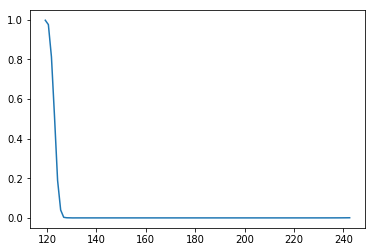

In [11]:
plt.figure()
plt.plot(ll,dd)
plt.show()

### The stream is completely destroyed!

### Try with an impact 6 Gyr in the past

In [12]:
with open('GD1_oldimpactstest_MW2014_leadingarm.pkl','rb') as savefile:
            #sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')

In [13]:
apar_full,x_full,y_full,z_full,vx_full,vy_full,vz_full = GMC_util.aparxv_stream(sdf_smooth,sdf_pepper)

# randomly select an apar and its velocity
tim=2 #impact at 6 Gyr in the past

apar_imp=apar_full[tim][10]
v_imp=np.c_[vx_full[tim][10]+0.0001,vy_full[tim][10]-0.0001,vz_full[tim][10]+0.002]
M_imp=10**9./bovy_conversion.mass_in_msol(vo,ro)
timp=sdf_pepper._timpact[tim]

def rs(M):
    return 1.05*(M/10**8.)**(0.5)

rs_imp=rs(10**9.)/8.

print (rs_imp)

print (v_imp)


0.4150489428970998
[[ 0.46804216  0.35419    -0.06945899]]


In [14]:
#import streampepperdf

sdf_pepper.set_impacts(impactb=[0.1/8.],subhalovel=v_imp,impact_angle=[apar_imp],timpact=[timp],rs=[rs_imp],GM=[M_imp])

apar=np.linspace(0.03,1.14,100)

dens_unp=[]
dens=[]
omega_unp=[]
omega=[]

for a in apar :
    dens_unp.append(sdf_smooth._density_par(a))
    omega_unp.append(sdf_smooth.meanOmega(a,oned=True))
    dens.append(sdf_pepper._densityAndOmega_par_approx(a)[0])
    omega.append(sdf_pepper._densityAndOmega_par_approx(a)[1])
    

dens_unp=np.array(dens_unp)
dens=np.array(dens)
omega=np.array(omega)

print (dens)


[1.00002320e+00 1.00002319e+00 1.00002319e+00 1.00002317e+00
 1.00002315e+00 1.00002312e+00 1.00002306e+00 1.00002295e+00
 1.00002278e+00 1.00002251e+00 1.00002206e+00 1.00002133e+00
 1.00002018e+00 1.00001836e+00 1.00001552e+00 1.00001114e+00
 1.00000445e+00 9.99994326e-01 9.99979160e-01 9.99956672e-01
 9.99923664e-01 9.99875698e-01 9.99806698e-01 9.99708439e-01
 9.99569917e-01 9.99376598e-01 9.99109516e-01 9.98744234e-01
 9.98249666e-01 9.97586783e-01 9.96707229e-01 9.95551913e-01
 9.94049625e-01 9.92115791e-01 9.89651460e-01 9.86542663e-01
 9.82660270e-01 9.77860501e-01 9.71986217e-01 9.64869117e-01
 9.56332908e-01 9.46197514e-01 9.34284271e-01 9.20422045e-01
 9.04454074e-01 8.86245323e-01 8.65690001e-01 8.42718884e-01
 8.17306017e-01 7.89474370e-01 7.59300025e-01 7.26914532e-01
 6.92505151e-01 6.56312789e-01 6.18627600e-01 5.79782327e-01
 5.40143632e-01 5.00101772e-01 4.60059120e-01 4.20418072e-01
 3.81568957e-01 3.43878548e-01 3.07679741e-01 2.73262871e-01
 2.40869047e-01 2.106857

In [15]:
def convert_dens_to_obs(apars,dens,dens_smooth,mO,poly_deg=3,poly_norm=True):
    """
    NAME:
        convert_dens_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
        poly_deg= (3) degree of the polynomial to fit for the 'smooth' stream
    OUTPUT:
        (xi,dens/smooth)
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    outll= numpy.linspace(numpy.amin(mT[0]),numpy.amax(mT[0]),len(apars))
    #phi12=lb_to_phi12(mT[0],mT[1],degree=True)
    #print (phi12[:,0])
    
    pp= Polynomial.fit(apars,dens,deg=3)
    outphi1= numpy.arange(0.25,14.35,0.1)
    # Interpolate density
    ipll= interpolate.InterpolatedUnivariateSpline(mT[0],apars)
    ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/dens_smooth)
    return (outll,ipdens(ipll(outll)))

ll,dd=convert_dens_to_obs(apar,dens,dens_unp,omega)
    

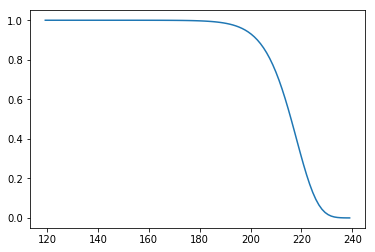

In [16]:
plt.figure()
plt.plot(ll,dd)
plt.show()

### Seems like no effect!